# Model-Based RL
In this exercise you will implement a policy and model network which work in tandem to solve the CartPole reinforcement learning problem.

What is a model and why would we want to use one? In this case, a model is going to be a neural network that attempts to learn the dynamics of the real environment. For example, in the CartPole we would like a model to be able to predict the next position of the Cart given the previous position and an action. By learning an accurate model, we can train our agent using the model rather than requiring to use the real environment every time. 

How are we going to accomplish this in Tensorflow? We are going to be using a neural network that will learn the transition dynamics between a previous observation and action, and the expected new observation, reward, and done state. Our training procedure will involve switching between training our model using the real environment, and training our agent’s policy using the model environment. By using this approach we will be able to learn a policy that allows our agent to solve the CartPole task without actually ever training the policy on the real environment! 

### Loading libraries and starting CartPole environment

In [1]:
from __future__ import print_function
import numpy as np
try:
    import cPickle as pickle
except:
    import pickle
import tensorflow as tf
%matplotlib inline
import matplotlib.pyplot as plt
import math

In [2]:
import sys
if sys.version_info.major > 2:
    xrange = range
del sys

In [3]:
import gym
env = gym.make('CartPole-v0')

[2017-07-21 10:48:33,259] Making new env: CartPole-v0


### Setting Hyper-parameters

In [4]:
# hyperparameters
H = 8 # number of hidden layer neurons
learning_rate = 1e-2
gamma = 0.99 # discount factor for reward
decay_rate = 0.99 # decay factor for RMSProp leaky sum of grad^2
resume = False # resume from previous checkpoint?

model_bs = 3 # Batch size when learning from model
real_bs = 3 # Batch size when learning from real environment

# model initialization
D = 4 # input dimensionality

### Policy Network

In [6]:
tf.reset_default_graph()
observations = tf.placeholder(tf.float32, [None,4] , name="input_x")
W1 = tf.get_variable("W1", shape=[4, H],
           initializer=tf.contrib.layers.xavier_initializer())
layer1 = tf.nn.relu(tf.matmul(observations,W1))
W2 = tf.get_variable("W2", shape=[H, 1],
           initializer=tf.contrib.layers.xavier_initializer())
score = tf.matmul(layer1,W2)
probability = tf.nn.sigmoid(score)

tvars = tf.trainable_variables()
input_y = tf.placeholder(tf.float32,[None,1], name="input_y")
advantages = tf.placeholder(tf.float32,name="reward_signal")
adam = tf.train.AdamOptimizer(learning_rate=learning_rate)
W1Grad = tf.placeholder(tf.float32,name="batch_grad1")
W2Grad = tf.placeholder(tf.float32,name="batch_grad2")
batchGrad = [W1Grad,W2Grad]

################################################################################
# TODO: Implement the loss function.                                           #
# This sends the weights in the direction of making actions that gave good     #
# advantage (reward overtime) more likely, and actions that didn't less likely.#
################################################################################
pass
################################################################################
#                                 END OF YOUR CODE                             #
################################################################################

newGrads = tf.gradients(loss,tvars)
updateGrads = adam.apply_gradients(zip(batchGrad,tvars))

NameError: name 'loss' is not defined

### Model Network
Here we implement a multi-layer neural network that predicts the next observation, reward, and done state from a current state and action.

In [7]:
mH = 256 # model layer size

input_data = tf.placeholder(tf.float32, [None, 5])
with tf.variable_scope('rnnlm'):
    softmax_w = tf.get_variable("softmax_w", [mH, 50])
    softmax_b = tf.get_variable("softmax_b", [50])

previous_state = tf.placeholder(tf.float32, [None,5] , name="previous_state")
W1M = tf.get_variable("W1M", shape=[5, mH],
           initializer=tf.contrib.layers.xavier_initializer())
B1M = tf.Variable(tf.zeros([mH]),name="B1M")
layer1M = tf.nn.relu(tf.matmul(previous_state,W1M) + B1M)
W2M = tf.get_variable("W2M", shape=[mH, mH],
           initializer=tf.contrib.layers.xavier_initializer())
B2M = tf.Variable(tf.zeros([mH]),name="B2M")
layer2M = tf.nn.relu(tf.matmul(layer1M,W2M) + B2M)
wO = tf.get_variable("wO", shape=[mH, 4],
           initializer=tf.contrib.layers.xavier_initializer())
wR = tf.get_variable("wR", shape=[mH, 1],
           initializer=tf.contrib.layers.xavier_initializer())
wD = tf.get_variable("wD", shape=[mH, 1],
           initializer=tf.contrib.layers.xavier_initializer())

bO = tf.Variable(tf.zeros([4]),name="bO")
bR = tf.Variable(tf.zeros([1]),name="bR")
bD = tf.Variable(tf.ones([1]),name="bD")


predicted_observation = tf.matmul(layer2M,wO,name="predicted_observation") + bO
predicted_reward = tf.matmul(layer2M,wR,name="predicted_reward") + bR
predicted_done = tf.sigmoid(tf.matmul(layer2M,wD,name="predicted_done") + bD)

true_observation = tf.placeholder(tf.float32,[None,4],name="true_observation")
true_reward = tf.placeholder(tf.float32,[None,1],name="true_reward")
true_done = tf.placeholder(tf.float32,[None,1],name="true_done")


predicted_state = tf.concat([predicted_observation,predicted_reward,predicted_done],1)

observation_loss = tf.square(true_observation - predicted_observation)

reward_loss = tf.square(true_reward - predicted_reward)

done_loss = tf.multiply(predicted_done, true_done) + tf.multiply(1-predicted_done, 1-true_done)
done_loss = -tf.log(done_loss)

model_loss = tf.reduce_mean(observation_loss + done_loss + reward_loss)

modelAdam = tf.train.AdamOptimizer(learning_rate=learning_rate)
updateModel = modelAdam.minimize(model_loss)

### Helper-functions

In [8]:
def resetGradBuffer(gradBuffer):
    for ix,grad in enumerate(gradBuffer):
        gradBuffer[ix] = grad * 0
    return gradBuffer

def discount_rewards(r):
    ################################################################################
    # TODO: Implement the discounted rewards function                              #
    # Return discounted rewards weighed by gamma. Each reward will be replaced     #
    # with a weight reward that involves itself and all the other rewards occuring #
    # after it. The later the reward after it happens, the less effect it has on   #
    # the current rewards's discounted reward                                      #
    # Hint: [r0, r1, r2, ..., r_N] will look someting like:                        #
    #       [(r0 + r1*gamma^1 + ... r_N*gamma^N), (r1 + r2*gamma^1 + ...), ...]    #
    ################################################################################
    pass   
    ################################################################################
    #                                 END OF YOUR CODE                             #
    ################################################################################

# This function uses our model to produce a new state when given a previous state and action
def stepModel(sess, xs, action):
    toFeed = np.reshape(np.hstack([xs[-1][0],np.array(action)]),[1,5])
    myPredict = sess.run([predicted_state],feed_dict={previous_state: toFeed})
    reward = myPredict[0][:,4]
    observation = myPredict[0][:,0:4]
    observation[:,0] = np.clip(observation[:,0],-2.4,2.4)
    observation[:,2] = np.clip(observation[:,2],-0.4,0.4)
    doneP = np.clip(myPredict[0][:,5],0,1)
    if doneP > 0.1 or len(xs)>= 300:
        done = True
    else:
        done = False
    return observation, reward, done

## Training the Policy and Model

In [9]:
xs,drs,ys,ds = [],[],[],[]
running_reward = None
reward_sum = 0
episode_number = 1
real_episodes = 1
init = tf.global_variables_initializer()
batch_size = real_bs

drawFromModel = False # When set to True, will use model for observations
trainTheModel = True # Whether to train the model
trainThePolicy = False # Whether to train the policy
switch_point = 1

# Launch the graph
with tf.Session() as sess:
    rendering = False
    sess.run(init)
    observation = env.reset()
    x = observation
    gradBuffer = sess.run(tvars)
    gradBuffer = resetGradBuffer(gradBuffer)
    
    while episode_number <= 5000:
        # Start displaying environment once performance is acceptably high.
        if (reward_sum/batch_size > 150 and drawFromModel == False) or rendering == True : 
            env.render()
            rendering = True
            
        x = np.reshape(observation,[1,4])

        tfprob = sess.run(probability,feed_dict={observations: x})
        action = 1 if np.random.uniform() < tfprob else 0

        # record various intermediates (needed later for backprop)
        xs.append(x) 
        y = 1 if action == 0 else 0 
        ys.append(y)
        
        # step the  model or real environment and get new measurements
        if drawFromModel == False:
            observation, reward, done, info = env.step(action)
        else:
            observation, reward, done = stepModel(sess,xs,action)
                
        reward_sum += reward
        
        ds.append(done*1)
        drs.append(reward) # record reward (has to be done after we call step() to get reward for previous action)

        if done: 
            
            if drawFromModel == False: 
                real_episodes += 1
            episode_number += 1

            # stack together all inputs, hidden states, action gradients, and rewards for this episode
            epx = np.vstack(xs)
            epy = np.vstack(ys)
            epr = np.vstack(drs)
            epd = np.vstack(ds)
            xs,drs,ys,ds = [],[],[],[] # reset array memory
            
            if trainTheModel == True:
                
                ################################################################################
                # TODO: Implement training of the mode                                         #
                ################################################################################
                pass
                ################################################################################
                #                                 END OF YOUR CODE                             #
                ################################################################################
                

            if trainThePolicy == True:
                
                ################################################################################
                # TODO: Implement training of the policy                                       #
                ################################################################################
                pass
                ################################################################################
                #                                 END OF YOUR CODE                             #
                ################################################################################
                
                # If gradients becom too large, end training process
                if np.sum(tGrad[0] == tGrad[0]) == 0:
                    break
                for ix,grad in enumerate(tGrad):
                    gradBuffer[ix] += grad
                
            if switch_point + batch_size == episode_number: 
                switch_point = episode_number
                if trainThePolicy == True:
                    sess.run(updateGrads,feed_dict={W1Grad: gradBuffer[0],W2Grad:gradBuffer[1]})
                    gradBuffer = resetGradBuffer(gradBuffer)

                running_reward = reward_sum if running_reward is None else running_reward * 0.99 + reward_sum * 0.01
                if drawFromModel == False:
                    print('World Perf: Episode %f. Reward %f. action: %f. mean reward %f.' % (real_episodes,reward_sum/real_bs,action, running_reward/real_bs))
                    if reward_sum/batch_size > 200:
                        break
                reward_sum = 0

                # Once the model has been trained on 100 episodes
                if episode_number > 100:
                    
                    ################################################################################
                    # TODO: Alternating between training the policy from the model and training    #
                    # the model from the real environment.                                         #
                    ################################################################################
                    pass
                    ################################################################################
                    #                                 END OF YOUR CODE                             #
                    ################################################################################
            
            if drawFromModel == True:
                observation = np.random.uniform(-0.1,0.1,[4]) # Generate reasonable starting point
                batch_size = model_bs
            else:
                observation = env.reset()
                batch_size = real_bs
                
print(real_episodes)

World Perf: Episode 4.000000. Reward 33.333333. action: 0.000000. mean reward 33.333333.
World Perf: Episode 7.000000. Reward 40.000000. action: 0.000000. mean reward 33.400000.
World Perf: Episode 10.000000. Reward 32.666667. action: 1.000000. mean reward 33.392667.
World Perf: Episode 13.000000. Reward 39.333333. action: 0.000000. mean reward 33.452073.
World Perf: Episode 16.000000. Reward 24.333333. action: 1.000000. mean reward 33.360886.
World Perf: Episode 19.000000. Reward 13.666667. action: 1.000000. mean reward 33.163944.
World Perf: Episode 22.000000. Reward 19.666667. action: 0.000000. mean reward 33.028971.
World Perf: Episode 25.000000. Reward 19.000000. action: 0.000000. mean reward 32.888681.
World Perf: Episode 28.000000. Reward 27.333333. action: 1.000000. mean reward 32.833128.
World Perf: Episode 31.000000. Reward 27.333333. action: 1.000000. mean reward 32.778130.
World Perf: Episode 34.000000. Reward 21.333333. action: 1.000000. mean reward 32.663682.
World Perf: 

World Perf: Episode 277.000000. Reward 41.000000. action: 1.000000. mean reward 29.312701.
World Perf: Episode 280.000000. Reward 16.333333. action: 1.000000. mean reward 29.182907.
World Perf: Episode 283.000000. Reward 29.000000. action: 1.000000. mean reward 29.181078.
World Perf: Episode 286.000000. Reward 45.333333. action: 1.000000. mean reward 29.342601.
World Perf: Episode 289.000000. Reward 25.666667. action: 1.000000. mean reward 29.305842.
World Perf: Episode 292.000000. Reward 17.666667. action: 1.000000. mean reward 29.189450.
World Perf: Episode 295.000000. Reward 20.666667. action: 0.000000. mean reward 29.104222.
World Perf: Episode 298.000000. Reward 16.333333. action: 1.000000. mean reward 28.976513.
World Perf: Episode 301.000000. Reward 26.666667. action: 0.000000. mean reward 28.953415.
World Perf: Episode 304.000000. Reward 40.333333. action: 1.000000. mean reward 29.067214.
World Perf: Episode 307.000000. Reward 16.666667. action: 1.000000. mean reward 28.943208.

World Perf: Episode 562.000000. Reward 27.333333. action: 1.000000. mean reward 28.232231.
World Perf: Episode 565.000000. Reward 15.333333. action: 1.000000. mean reward 28.103242.
World Perf: Episode 568.000000. Reward 24.000000. action: 0.000000. mean reward 28.062209.
World Perf: Episode 571.000000. Reward 21.666667. action: 1.000000. mean reward 27.998254.
World Perf: Episode 574.000000. Reward 32.333333. action: 1.000000. mean reward 28.041605.
World Perf: Episode 577.000000. Reward 17.333333. action: 0.000000. mean reward 27.934522.
World Perf: Episode 580.000000. Reward 27.666667. action: 0.000000. mean reward 27.931843.
World Perf: Episode 583.000000. Reward 29.000000. action: 1.000000. mean reward 27.942525.
World Perf: Episode 586.000000. Reward 32.000000. action: 1.000000. mean reward 27.983100.
World Perf: Episode 589.000000. Reward 26.666667. action: 0.000000. mean reward 27.969935.
World Perf: Episode 592.000000. Reward 21.666667. action: 1.000000. mean reward 27.906903.

World Perf: Episode 835.000000. Reward 46.000000. action: 0.000000. mean reward 26.515292.
World Perf: Episode 838.000000. Reward 34.666667. action: 0.000000. mean reward 26.596806.
World Perf: Episode 841.000000. Reward 34.000000. action: 1.000000. mean reward 26.670838.
World Perf: Episode 844.000000. Reward 26.333333. action: 0.000000. mean reward 26.667463.
World Perf: Episode 847.000000. Reward 22.000000. action: 0.000000. mean reward 26.620788.
World Perf: Episode 850.000000. Reward 35.333333. action: 1.000000. mean reward 26.707913.
World Perf: Episode 853.000000. Reward 13.666667. action: 1.000000. mean reward 26.577501.
World Perf: Episode 856.000000. Reward 15.000000. action: 0.000000. mean reward 26.461726.
World Perf: Episode 859.000000. Reward 19.333333. action: 1.000000. mean reward 26.390442.
World Perf: Episode 862.000000. Reward 13.666667. action: 1.000000. mean reward 26.263204.
World Perf: Episode 865.000000. Reward 17.000000. action: 0.000000. mean reward 26.170572.

World Perf: Episode 1105.000000. Reward 25.000000. action: 1.000000. mean reward 25.433421.
World Perf: Episode 1108.000000. Reward 24.333333. action: 1.000000. mean reward 25.422420.
World Perf: Episode 1111.000000. Reward 36.000000. action: 1.000000. mean reward 25.528196.
World Perf: Episode 1114.000000. Reward 28.666667. action: 1.000000. mean reward 25.559580.
World Perf: Episode 1117.000000. Reward 25.333333. action: 0.000000. mean reward 25.557318.
World Perf: Episode 1120.000000. Reward 18.333333. action: 0.000000. mean reward 25.485078.
World Perf: Episode 1123.000000. Reward 31.000000. action: 1.000000. mean reward 25.540227.
World Perf: Episode 1126.000000. Reward 21.000000. action: 1.000000. mean reward 25.494825.
World Perf: Episode 1129.000000. Reward 36.333333. action: 0.000000. mean reward 25.603210.
World Perf: Episode 1132.000000. Reward 25.666667. action: 1.000000. mean reward 25.603845.
World Perf: Episode 1135.000000. Reward 32.666667. action: 0.000000. mean reward

World Perf: Episode 1375.000000. Reward 35.333333. action: 1.000000. mean reward 25.497920.
World Perf: Episode 1378.000000. Reward 28.000000. action: 1.000000. mean reward 25.522940.
World Perf: Episode 1381.000000. Reward 13.333333. action: 1.000000. mean reward 25.401044.
World Perf: Episode 1384.000000. Reward 33.333333. action: 1.000000. mean reward 25.480367.
World Perf: Episode 1387.000000. Reward 11.666667. action: 0.000000. mean reward 25.342230.
World Perf: Episode 1390.000000. Reward 26.666667. action: 1.000000. mean reward 25.355475.
World Perf: Episode 1393.000000. Reward 25.333333. action: 1.000000. mean reward 25.355253.
World Perf: Episode 1396.000000. Reward 21.000000. action: 0.000000. mean reward 25.311701.
World Perf: Episode 1399.000000. Reward 23.333333. action: 1.000000. mean reward 25.291917.
World Perf: Episode 1402.000000. Reward 23.000000. action: 0.000000. mean reward 25.268998.
World Perf: Episode 1405.000000. Reward 25.666667. action: 0.000000. mean reward

World Perf: Episode 1651.000000. Reward 32.333333. action: 1.000000. mean reward 26.308791.
World Perf: Episode 1654.000000. Reward 18.333333. action: 1.000000. mean reward 26.229037.
World Perf: Episode 1657.000000. Reward 20.333333. action: 0.000000. mean reward 26.170080.
World Perf: Episode 1660.000000. Reward 13.666667. action: 0.000000. mean reward 26.045046.
World Perf: Episode 1663.000000. Reward 27.666667. action: 1.000000. mean reward 26.061262.
World Perf: Episode 1666.000000. Reward 30.333333. action: 0.000000. mean reward 26.103982.
World Perf: Episode 1669.000000. Reward 28.333333. action: 0.000000. mean reward 26.126276.
World Perf: Episode 1672.000000. Reward 37.333333. action: 1.000000. mean reward 26.238347.
World Perf: Episode 1675.000000. Reward 36.000000. action: 1.000000. mean reward 26.335963.
World Perf: Episode 1678.000000. Reward 16.000000. action: 1.000000. mean reward 26.232603.
World Perf: Episode 1681.000000. Reward 19.666667. action: 1.000000. mean reward

World Perf: Episode 1930.000000. Reward 26.666667. action: 1.000000. mean reward 26.156274.
World Perf: Episode 1933.000000. Reward 27.000000. action: 1.000000. mean reward 26.164711.
World Perf: Episode 1936.000000. Reward 18.666667. action: 1.000000. mean reward 26.089731.
World Perf: Episode 1939.000000. Reward 17.000000. action: 1.000000. mean reward 25.998834.
World Perf: Episode 1942.000000. Reward 28.000000. action: 0.000000. mean reward 26.018845.
World Perf: Episode 1945.000000. Reward 50.333333. action: 0.000000. mean reward 26.261990.
World Perf: Episode 1948.000000. Reward 36.000000. action: 1.000000. mean reward 26.359370.
World Perf: Episode 1951.000000. Reward 27.666667. action: 0.000000. mean reward 26.372443.
World Perf: Episode 1954.000000. Reward 30.666667. action: 1.000000. mean reward 26.415386.
World Perf: Episode 1957.000000. Reward 20.000000. action: 1.000000. mean reward 26.351232.
World Perf: Episode 1960.000000. Reward 22.333333. action: 0.000000. mean reward

World Perf: Episode 2209.000000. Reward 43.666667. action: 1.000000. mean reward 26.121035.
World Perf: Episode 2212.000000. Reward 27.000000. action: 1.000000. mean reward 26.129825.
World Perf: Episode 2215.000000. Reward 17.666667. action: 1.000000. mean reward 26.045193.
World Perf: Episode 2218.000000. Reward 22.666667. action: 0.000000. mean reward 26.011408.
World Perf: Episode 2221.000000. Reward 20.000000. action: 0.000000. mean reward 25.951294.
World Perf: Episode 2224.000000. Reward 23.000000. action: 1.000000. mean reward 25.921781.
World Perf: Episode 2227.000000. Reward 33.666667. action: 1.000000. mean reward 25.999230.
World Perf: Episode 2230.000000. Reward 49.333333. action: 0.000000. mean reward 26.232571.
World Perf: Episode 2233.000000. Reward 21.666667. action: 1.000000. mean reward 26.186912.
World Perf: Episode 2236.000000. Reward 17.000000. action: 1.000000. mean reward 26.095043.
World Perf: Episode 2239.000000. Reward 26.333333. action: 1.000000. mean reward

World Perf: Episode 2485.000000. Reward 43.333333. action: 1.000000. mean reward 26.435073.
World Perf: Episode 2488.000000. Reward 25.333333. action: 1.000000. mean reward 26.424055.
World Perf: Episode 2491.000000. Reward 15.333333. action: 1.000000. mean reward 26.313148.
World Perf: Episode 2494.000000. Reward 32.333333. action: 0.000000. mean reward 26.373350.
World Perf: Episode 2497.000000. Reward 35.666667. action: 0.000000. mean reward 26.466283.
World Perf: Episode 2500.000000. Reward 34.666667. action: 1.000000. mean reward 26.548287.
World Perf: Episode 2503.000000. Reward 30.666667. action: 1.000000. mean reward 26.589471.
World Perf: Episode 2506.000000. Reward 32.666667. action: 1.000000. mean reward 26.650243.
World Perf: Episode 2509.000000. Reward 15.000000. action: 1.000000. mean reward 26.533740.
World Perf: Episode 2512.000000. Reward 16.666667. action: 0.000000. mean reward 26.435070.
World Perf: Episode 2515.000000. Reward 40.333333. action: 1.000000. mean reward

KeyboardInterrupt: 

### Checking model representation
Here we can examine how well the model is able to approximate the true environment after training. The green line indicates the real environment, and the blue indicates model predictions.

NameError: name 'pState' is not defined

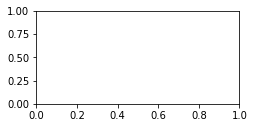

In [11]:
plt.figure(figsize=(8, 12))
for i in range(6):
    plt.subplot(6, 2, 2*i + 1)
    plt.plot(pState[:,i])
    plt.subplot(6,2,2*i+1)
    plt.plot(state_nextsAll[:,i])
plt.tight_layout()